## PySpark Basics in CML

**Apache Spark is a general purpose framework for distributed computing that offers high performance for both batch and stream processing. It exposes APIs for Java, Python, R, and Scala, as well as an interactive shell for you to run jobs.**

**In Cloudera Machine Learning (CML), Spark and its dependencies are bundled directly into the CML engine Docker image or CML Runtime. CML supports fully-containerized execution of Spark workloads via Spark's support for the Kubernetes cluster backend. Users can interact with Spark both interactively and in batch mode.**

 

![title](img/sparkonk8s.png)

**The bottom line: Spark on CML is dramatically easier to use than Spark on Yarn on CDSW or other platforms. There is no need to distribute dependencies among execuotors. You can easily spin up multi-executor distributed Spark Sessions and interrupt them as needed, all within quotas and other cost monitoring constraints**

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

**A simple, single pod Spark Session can be instantiated as shown below. This creates a single pod for the Spark application**

In [3]:
spark = SparkSession\
    .builder\
    .master("local[*]")\
    .appName("SimpleSession")\
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/16 03:56:27 WARN JettyUtils: GET /jobs/ failed: java.util.NoSuchElementException: Failed to get the application information. If you are starting up Spark, please wait a while until it's ready.
java.util.NoSuchElementException: Failed to get the application information. If you are starting up Spark, please wait a while until it's ready.
	at org.apache.spark.status.AppStatusStore.applicationInfo(AppStatusStore.scala:51)
	at org.apache.spark.ui.jobs.AllJobsPage.render(AllJobsPage.scala:276)
	at org.apache.spark.ui.WebUI.$anonfun$attachPage$1(WebUI.scala:90)
	at org.apache.spark.ui.JettyUtils$$anon$1.doGet(JettyUtils.scala:81)
	at javax.servlet.http.HttpServlet.service(HttpServlet.java:687)
	at javax.servlet.http.HttpServlet.service(HttpServlet.java:790)
	at org.sparkproject.je

In [4]:
spark

In [5]:
import os
print("https://spark-"+os.environ["CDSW_ENGINE_ID"]+"."+os.environ["CDSW_DOMAIN"])

https://spark-m1j5qguflp44636k.ml-9d3fb570-b59.col1-cdp.xfaz-gdb4.cloudera.site


You can reach the Spark UI from the URL as shown above.

![title](img/spark_ui.png)

You can stop the Spark session any time as below

Let's try a Spark Session with more horsepower. You can increase number of cores and memory for the Driver and Executors with the following settings

In [6]:
"""spark = SparkSession\
    .builder\
    .master("local")\
    .appName("DistributedSession")\
    .config("spark.executor.memory","2g")\
    .config("spark.executor.cores","5")\
    .config("spark.driver.memory","2g")\
    .getOrCreate()"""

'spark = SparkSession    .builder    .master("local")    .appName("DistributedSession")    .config("spark.executor.memory","2g")    .config("spark.executor.cores","5")    .config("spark.driver.memory","2g")    .getOrCreate()'

You just created a distributed Spark Session with 1 Driver and 5 Executors. Each Executor has 8 cores and 2GB of memory. Not bad!

In [7]:
spark.stop()

## Spark Data Connections

The best way to launch a spark session is however Spark Data Connections. This feature provides the code you need to launch your Spark Session and already includes the Iceberg jars to enable Lakehouse analytics!

To launch a Spark Data Connection, open "Data" and pick the "Spark" option. Then copy paste the code into the cell below:

![title](img/dataconnections.png)

In [8]:
import cml.data_v1 as cmldata

# Sample in-code customization of spark configurations
#from pyspark import SparkContext
#SparkContext.setSystemProperty('spark.executor.cores', '1')
#SparkContext.setSystemProperty('spark.executor.memory', '2g')

CONNECTION_NAME = "col1-aw-dl"

conn = cmldata.get_connection(CONNECTION_NAME)
spark = conn.get_spark_session()

# Sample usage to run query through spark
EXAMPLE_SQL_QUERY = "show databases"
spark.sql(EXAMPLE_SQL_QUERY).show()

24/04/16 03:56:29 WARN SparkConf: The configuration key 'spark.yarn.access.hadoopFileSystems' has been deprecated as of Spark 3.0 and may be removed in the future. Please use the new key 'spark.kerberos.access.hadoopFileSystems' instead.
24/04/16 03:56:30 WARN JettyUtils: GET /jobs/ failed: java.util.NoSuchElementException: Failed to get the application information. If you are starting up Spark, please wait a while until it's ready.
java.util.NoSuchElementException: Failed to get the application information. If you are starting up Spark, please wait a while until it's ready.
	at org.apache.spark.status.AppStatusStore.applicationInfo(AppStatusStore.scala:51)
	at org.apache.spark.ui.jobs.AllJobsPage.render(AllJobsPage.scala:276)
	at org.apache.spark.ui.WebUI.$anonfun$attachPage$1(WebUI.scala:90)
	at org.apache.spark.ui.JettyUtils$$anon$1.doGet(JettyUtils.scala:81)
	at javax.servlet.http.HttpServlet.service(HttpServlet.java:687)
	at javax.servlet.http.HttpServlet.service(HttpServlet.java:

+-------------------+
|          namespace|
+-------------------+
|            default|
| information_schema|
|                sys|
|trafico_pauldefusco|
+-------------------+



## Intro to Spark SQL

In [9]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
df = spark.read.option("inferschema", True).option("header", True).csv('data/crimen_sample.csv')

In [11]:
#Printing number of rows and columns:
print('Dataframe Shape')
print((df.count(), len(df.columns)))

Dataframe Shape
(50000, 19)


In [12]:
df.show()

+--------------------+----------+-----+--------------------+----------------+----------------+-----+-----------------+-------+--------------+----------+-------------------+--------+--------+---------+---------------+----------------+-------+-----------+
|              nombre|docu_ident| edad|          profession|         num_tel|quejas_por_ruido|robos|robos_mano_armada|asaltos|robos_vehiculo|vandalismo|incendios_provocado|longitud| latitud|homicidio|abusos_infantil|abusos_domestico|estafas|reincidente|
+--------------------+----------+-----+--------------------+----------------+----------------+-----+-----------------+-------+--------------+----------+-------------------+--------+--------+---------+---------------+----------------+-------+-----------+
|Teodora Milla-Nic...| Y21130180|100.0|           Tronzador|  +34982 558 524|             1.0|  3.0|              3.0|    1.0|           3.0|       1.0|                0.0|  6.2456|-75.5629|      1.0|            1.0|             6.0|    7

In [13]:
df.printSchema()

root
 |-- nombre: string (nullable = true)
 |-- docu_ident: string (nullable = true)
 |-- edad: double (nullable = true)
 |-- profession: string (nullable = true)
 |-- num_tel: string (nullable = true)
 |-- quejas_por_ruido: double (nullable = true)
 |-- robos: double (nullable = true)
 |-- robos_mano_armada: double (nullable = true)
 |-- asaltos: double (nullable = true)
 |-- robos_vehiculo: double (nullable = true)
 |-- vandalismo: double (nullable = true)
 |-- incendios_provocado: double (nullable = true)
 |-- longitud: double (nullable = true)
 |-- latitud: double (nullable = true)
 |-- homicidio: double (nullable = true)
 |-- abusos_infantil: double (nullable = true)
 |-- abusos_domestico: double (nullable = true)
 |-- estafas: double (nullable = true)
 |-- reincidente: integer (nullable = true)



## KPI Reporting

In [14]:
import pyspark.sql.functions as F
import seaborn as sns
from pyspark.ml.feature import Bucketizer

#### Min and Max Lat / Long Amount 

In [15]:
print("Minimum Latitude")
df.agg(F.min("latitud")).show()

print("Maximum Longitude")
df.agg(F.max("longitud")).show()

Minimum Latitude
+------------+
|min(latitud)|
+------------+
|    -76.5629|
+------------+

Maximum Longitude
+-------------+
|max(longitud)|
+-------------+
|       6.2456|
+-------------+



#### Create Bins from the Loan Amount Column

In [16]:
df2 = Bucketizer(
    splits=[0, 25, 50, 75, 100],
    inputCol='edad',
    outputCol='edad_bin'
).transform(df)

In [17]:
df2_pandas = df2.select("edad_bin").toPandas()
df2_pandas

,edad_bin
0,3.0
1,1.0
2,1.0
3,0.0
4,0.0
...,...
49995,3.0
49996,2.0
49997,2.0
49998,3.0


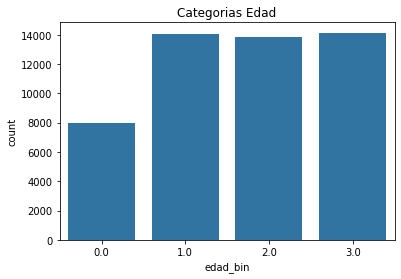

In [18]:
sns.countplot(x="edad_bin", data=df2_pandas).set(title='Categorias Edad')
plt.show()

### Rounded Mean Frauds By Noise Complaint Bins

In [19]:
#how many loans defaulted for each month (all data is 2015):
df2.groupby('edad_bin').mean('estafas').na.drop().select("edad_bin", F.ceil(F.col("avg(estafas)"))).show()

+--------+------------------+
|edad_bin|CEIL(avg(estafas))|
+--------+------------------+
|     0.0|                 5|
|     1.0|                 5|
|     3.0|                 6|
|     2.0|                 6|
+--------+------------------+



### Spark SQL

In [20]:
spark.sql("show databases").show()

+-------------------+
|          namespace|
+-------------------+
|            default|
| information_schema|
|                sys|
|trafico_pauldefusco|
+-------------------+



#### Saving the Table As Temporary View

In [21]:
## Registering the dataframe as a temporary table:
## Temporary views in Spark SQL are session-scoped and will disappear if the session that creates it terminates. 

df2.createOrReplaceTempView("my_temp_view")

In [22]:
spark.sql("SELECT nombre, docu_ident FROM my_temp_view WHERE vandalismo > 2 AND edad < 16").show()

+--------------------+----------+
|              nombre|docu_ident|
+--------------------+----------+
|  Paula Gimenez León| H67218539|
| Marciano Puig Casal| 208382887|
|Ezequiel Romeu Álamo| 301068599|
|Natalia Solsona B...| Z14319122|
|Osvaldo Arrieta A...| S49483925|
|  Adán Mariño Amores| V41192398|
|Eusebia Durán Her...| 488521765|
|Plácido Guardia V...| 069083395|
|      Azahara Quirós| 854362322|
|      Modesta Castro| G27909539|
|     Damián Mur Puga| X19786829|
|Eladio Ibáñez Fig...| 529229748|
|Nieves Bautista-F...| 627831795|
|     Amanda Gargallo| M25295650|
|Kike Heredia Portero| 251500920|
|Sarita Villalobos...| V15668701|
|   Desiderio Atienza| 986764474|
|  Pepe Gallego Calvo| 232030688|
|          Román Vila| 008369017|
|Ani María Manuela...| 070069967|
+--------------------+----------+
only showing top 20 rows



In [29]:
spark.sql("SELECT nombre, docu_ident, profession FROM my_temp_view WHERE profession == 'Agente de bolsa' AND estafas > 0").show()

+--------------------+----------+---------------+
|              nombre|docu_ident|     profession|
+--------------------+----------+---------------+
|Casandra Barrios-...| 478995297|Agente de bolsa|
|Antonio Ureña Murcia| 157259704|Agente de bolsa|
|   Azahar Peral Amor| 369720996|Agente de bolsa|
|Imelda Hernando-M...| F66665957|Agente de bolsa|
|   Mario Recio Rivas| 991243509|Agente de bolsa|
|       Gil Benavente| D68089425|Agente de bolsa|
|Flora Clavero Gal...| 401618766|Agente de bolsa|
| Cirino Cases Marcos| 779857722|Agente de bolsa|
|    Florencio Morera| 221604331|Agente de bolsa|
| Tamara Andres Palau| 857144171|Agente de bolsa|
| Fanny Vigil Tejedor| B90612846|Agente de bolsa|
|Úrsula Barroso Ramis| 338826887|Agente de bolsa|
|Consuelo del Camacho| 988063380|Agente de bolsa|
|Morena Pía Borreg...| N25125902|Agente de bolsa|
|Apolonia Villanue...| 504604007|Agente de bolsa|
|Tatiana Barros Po...| R46648964|Agente de bolsa|
|     Hernando Arnaiz| B68643740|Agente de bolsa|


In [24]:
spark.sql("SELECT reincidente, COUNT(nombre) FROM my_temp_view GROUP BY reincidente").show()

+-----------+-------------+
|reincidente|count(nombre)|
+-----------+-------------+
|          1|         5123|
|          0|        44877|
+-----------+-------------+



#### Saving the Table Permanently in CDW

In [23]:
## The table will now be a Hive External Table and will show in CDW and Atlas.
## Ranger Policies can now be set on the Table

#df2.select(["funded_amnt", "loan_amnt", "installment", "tot_cur_bal"]).write.format('parquet').mode("overwrite").saveAsTable('default.my_hive_table')

In [23]:
spark.stop()